### 1. Install libraries

In [ ]:
%pip install supertree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.5/321.5 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.0 MB/s eta 0:00:00
  Created wheel for supertree: filename=supertree-0.5.5-py3-none-any.whl size=223914 sha256=ddfdf7b1e2f54b8bfcb62fbcd93458ecedaad28c863358af968d0d98e11db3dd
  Stored in directory: /root/.cache/pip/wheels/94/d5/5f/2e4b444abd02194d56fa70a3ad54a41c856f5a680a23882100
Successfully built supertree


## 2. XGBoost Regression

=== Booster params (effective) ===
{}
User params: {'objective': 'reg:squarederror', 'eta': 0.5, 'lambda': 1.0, 'gamma': 0.0, 'max_depth': 1, 'base_score': 236.66666666666666, 'min_child_weight': 0.0, 'subsample': 1.0, 'tree_method': 'exact'}

ROUND 1  (analyzing TREE index 0)
Base score used (mean y): 236.666667
yhat_prev (first 10): [220.92889404296875, 238.61778259277344, 220.92889404296875, 250.36666870117188, 238.61778259277344, 250.36666870117188]
g (first 10): [16.928894, 4.617783, 17.928894, -18.633331, -11.382217, -9.633331]
h (first 10): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

[Tree 0] Node 0 (SPLIT): f0 < 42, gain=None, cover=None
  -> Computed (from data): G_L=34.857788, H_L=2.000000, G_R=-35.031097, H_R=4.000000
  -> Gain(theory) = 325.226532 | Gain(dump) = nan
  -> Cover(dump) = None   (For MSE, cover ≈ #samples = H)

[Tree 0] Node 0-L (LEAF): leaf=-11.0555573, cover=None
  -> Leaf stats: leaf(after eta)=-11.055557, w*(pre-eta)=-22.111115, cover=None

[Tree 0] Node 0-R (LEAF): le

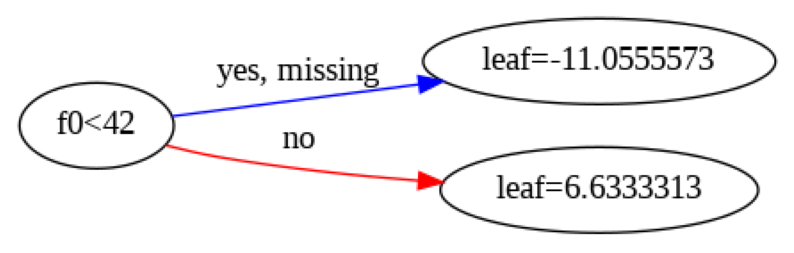

In [ ]:
# =======================
# XGBoost Regression (MSE)
# =======================

import numpy as np
import xgboost as xgb
import json
from supertree import SuperTree
from typing import Dict, Any, List, Tuple
# font serif for tree plot
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
from IPython.display import display


# -----------------------
# Utilities
# -----------------------
def mse_grad_hess(yhat: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """For MSE: l = 0.5*(y - yhat)^2 => g = yhat - y, h = 1."""
    g = yhat - y
    h = np.ones_like(y, dtype=float)
    return g, h

def xgb_gain(GL: float, HL: float, GR: float, HR: float, lmbd: float, gamma: float) -> float:
    """Gain formula (Eq. 7 style) used in XGBoost."""
    G = GL + GR
    H = HL + HR
    term = (GL**2) / (HL + lmbd) + (GR**2) / (HR + lmbd) - (G**2) / (H + lmbd)
    return 0.5 * term - gamma

def route_indices_binary(feature_values: np.ndarray, threshold: float, idx: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Split indices into left (<= thr) and right (> thr). (No missing handling here.)"""
    left_mask = feature_values[idx] <= threshold
    left_idx  = idx[left_mask]
    right_idx = idx[~left_mask]
    return left_idx, right_idx

def parse_tree_json(booster: xgb.Booster, tree_id: int) -> Dict[str, Any]:
    """Get a single tree structure as JSON dict."""
    # dump_format='json' returns a JSON string per tree
    dump_json = booster.get_dump(dump_format='json')[tree_id]
    return json.loads(dump_json)

def collect_feature_matrix(dmatrix: xgb.DMatrix) -> np.ndarray:
    """Extract the training matrix back (only if created from numpy)."""
    # NOTE: XGBoost does not expose raw data from DMatrix; we keep X outside when building DMatrix.
    raise RuntimeError("Pass original X (numpy array) to analyze; DMatrix does not expose raw features.")

def print_node_header(tree_idx: int, path: str, node: Dict[str, Any]):
    is_leaf = 'leaf' in node
    if is_leaf:
        print(f"[Tree {tree_idx}] Node {path} (LEAF): leaf={node['leaf']}, cover={node.get('cover')}")
    else:
        split_feat = node['split']         # e.g., 'f0'
        thr = node['split_condition']
        print(f"[Tree {tree_idx}] Node {path} (SPLIT): {split_feat} < {thr}, gain={node.get('gain')}, cover={node.get('cover')}")

def analyze_node_recursive(
    tree_idx: int,
    node: Dict[str, Any],
    X: np.ndarray,
    feat_names: List[str],
    idx: np.ndarray,
    g: np.ndarray,
    h: np.ndarray,
    params: Dict[str, Any],
    path: str = "0"
):
    """
    Recursively analyze a JSON node:
      - If split: compute (GL,HL,GR,HR), theoretical gain, compare with node["gain"]
      - Recurse to children with their respective index sets.
      - If leaf: print leaf value (already multiplied by eta), also show pre-shrink weight.
    """
    print_node_header(tree_idx, path, node)

    if 'leaf' in node:
        # Leaf value in JSON is already after shrinkage (eta * w*)
        leaf_after_eta = float(node['leaf'])
        eta = float(params.get("eta", 0.3))
        w_star = leaf_after_eta / eta  # pre-shrinkage leaf weight
        print(f"  -> Leaf stats: leaf(after eta)={leaf_after_eta:.6f}, w*(pre-eta)={w_star:.6f}, cover={node.get('cover')}\n")
        return

    # It's a split node
    split_name = node['split']  # e.g., "f0"
    # Map "f{k}" to column index
    assert split_name.startswith('f'), f"Unexpected split name: {split_name}"
    feat_idx = int(split_name[1:])
    thr = float(node['split_condition'])

    # Partition current indices into L/R
    left_idx, right_idx = route_indices_binary(X[:, feat_idx], thr, idx)

    # Compute GL, HL, GR, HR
    GL = float(g[left_idx].sum())
    HL = float(h[left_idx].sum())
    GR = float(g[right_idx].sum())
    HR = float(h[right_idx].sum())

    lmbd = float(params.get("lambda", params.get("reg_lambda", 1.0)))
    gamma = float(params.get("gamma", 0.0))

    theo_gain = xgb_gain(GL, HL, GR, HR, lmbd=lmbd, gamma=gamma)

    print(f"  -> Computed (from data): G_L={GL:.6f}, H_L={HL:.6f}, G_R={GR:.6f}, H_R={HR:.6f}")
    print(f"  -> Gain(theory) = {theo_gain:.6f} | Gain(dump) = {float(node.get('gain', 'nan')):.6f}")
    print(f"  -> Cover(dump) = {node.get('cover')}   (For MSE, cover ≈ #samples = H)")
    print()

    # Recurse to children.
    # In JSON, children appear under node["children"] (2 entries for binary split):
    # We don't rely on 'yes'/'no' ids; we recompute routing directly with threshold.
    children = node['children']
    # Determine which child is left/right by checking a single sample:
    # But easier: we can rely on our left_idx/right_idx sets and route accordingly
    # by split condition again in recursion.

    # We need to map child "nodeid" to its dict to detect which side to pass.
    # However, children already contain the subtree; we can route by condition again.
    # We'll call recursive with left/right idx based on threshold.
    # Order children in dump is typically: left (yes), right (no) — but not guaranteed.
    # We'll detect leaves by re-splitting at next level anyway.
    # To be explicit, try both children with appropriate idx:
    # Decide child side by evaluating its subtree with non-empty index set.

    # Child 0: try left indices
    if len(left_idx) > 0:
        analyze_node_recursive(tree_idx, children[0], X, feat_names, left_idx, g, h, params, path=path + "-L")
    else:
        analyze_node_recursive(tree_idx, children[0], X, feat_names, left_idx, g, h, params, path=path + "-L(empty)")

    # Child 1: right indices
    if len(right_idx) > 0:
        analyze_node_recursive(tree_idx, children[1], X, feat_names, right_idx, g, h, params, path=path + "-R")
    else:
        analyze_node_recursive(tree_idx, children[1], X, feat_names, right_idx, g, h, params, path=path + "-R(empty)")

def analyze_booster_regression_mse(
    X: np.ndarray,
    y: np.ndarray,
    params: Dict[str, Any],
    num_boost_round: int
):
    """
    Train an XGBoost regressor (MSE) and print, for each tree t:
      - previous predictions yhat^{(t-1)}
      - gradients g, h (h=1)
      - for every split node: (GL,HL,GR,HR), theoretical gain vs dump gain, cover
      - for every leaf: leaf(after eta), w*(pre-eta)
    """
    assert X.ndim == 2, "X should be 2-D array of shape (n_samples, n_features)"
    dtrain = xgb.DMatrix(X, label=y)

    # Ensure base_score equals mean(y) to match "theory" neatly (optional but recommended)
    params = dict(params)  # copy
    params.setdefault("objective", "reg:squarederror")
    params.setdefault("eta", 0.5)
    params.setdefault("lambda", 1.0)
    params.setdefault("gamma", 0.0)
    params.setdefault("max_depth", 1)
    params.setdefault("base_score", float(y.mean()))

    booster = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    print("=== Booster params (effective) ===")
    print({k: booster.attr(k) for k in ["base_score"] if booster.attr(k) is not None})
    print("User params:", params)
    print()

    # Analyze each boosting iteration t (tree index t-1)
    for t in range(1, num_boost_round + 1):
        print("="*70)
        print(f"ROUND {t}  (analyzing TREE index {t-1})")
        print("="*70)

        # yhat^{(t-1)}: use trees [0, t-1)
        # iteration_range=(0,t-1) uses trees up to t-1 (exclusive end)
        # For t=1, this yields base_score predictions
        yhat_prev = booster.predict(dtrain, iteration_range=(0, t-1), output_margin=True)
        g, h = mse_grad_hess(yhat_prev, y)

        print(f"Base score used (mean y): {params['base_score']:.6f}")
        print("yhat_prev (first 10):", np.round(yhat_prev, 6).tolist())
        print("g (first 10):", np.round(g, 6).tolist())
        print("h (first 10):", h[:10].tolist())
        print()

        # Parse tree JSON for tree t-1
        tree = parse_tree_json(booster, t-1)

        # (Optional) print raw JSON structure
        # print(json.dumps(tree, indent=2))

        # Recursively analyze this tree starting from all indices
        n = X.shape[0]
        idx_all = np.arange(n, dtype=int)
        feat_names = [f"f{k}" for k in range(X.shape[1])]
        analyze_node_recursive(
            tree_idx=t-1,
            node=tree,
            X=X,
            feat_names=feat_names,
            idx=idx_all,
            g=g,
            h=h,
            params=params,
            path="0"
        )

        # Also show predictions after adding this tree
        yhat_after = booster.predict(dtrain, iteration_range=(0, t), output_margin=True)
        print("Predictions after this round:", np.round(yhat_after, 6).tolist())
        print()

    # Final predictions
    yhat_final = booster.predict(dtrain)
    print("=== Final predictions (after all trees, with link=identity) ===")
    print(np.round(yhat_final, 6).tolist())
    return booster


# -----------------------
if __name__ == "__main__":
    # X = np.array([0, 1, 2, 3, 4, 5]).reshape(-1, 1)
    # y = np.array([0.0, 1.0, 1.5, 2.5, 3.0, 4.0])
    X = np.array([29,48,39,67,45,59]).reshape(-1, 1)
    y = np.array([204,234,203,269,250,260], dtype=float)


    params = {
        "objective": "reg:squarederror",
        "eta": 0.5,
        "lambda": 1.0,
        "gamma": 0.0,
        "max_depth": 1,
        "base_score": float(y.mean())
    }
    params.update({
        "min_child_weight": 0.0,
        "subsample": 1.0,
        "tree_method": "exact",
    })

    model = analyze_booster_regression_mse(X, y, params, num_boost_round=2)

    # st = SuperTree(
    #     model,
    #     X,
    #     y
    # )
    # st.show_tree()

    # xgb.plot_tree(model)

    fig, ax = plt.subplots(figsize=(50, 50))
    xgb.plot_tree(model, tree_idx=0, rankdir="LR", ax=ax)

    # fig = plt.gcf()
    # fig.set_size_inches(50, 30)  # tăng size để có độ phân giải cao
    # Lưu ra file PDF
    plt.savefig("tree.png", format="png", dpi=300, bbox_inches="tight")
    plt.show()

    plt.close()


Num trees: 2


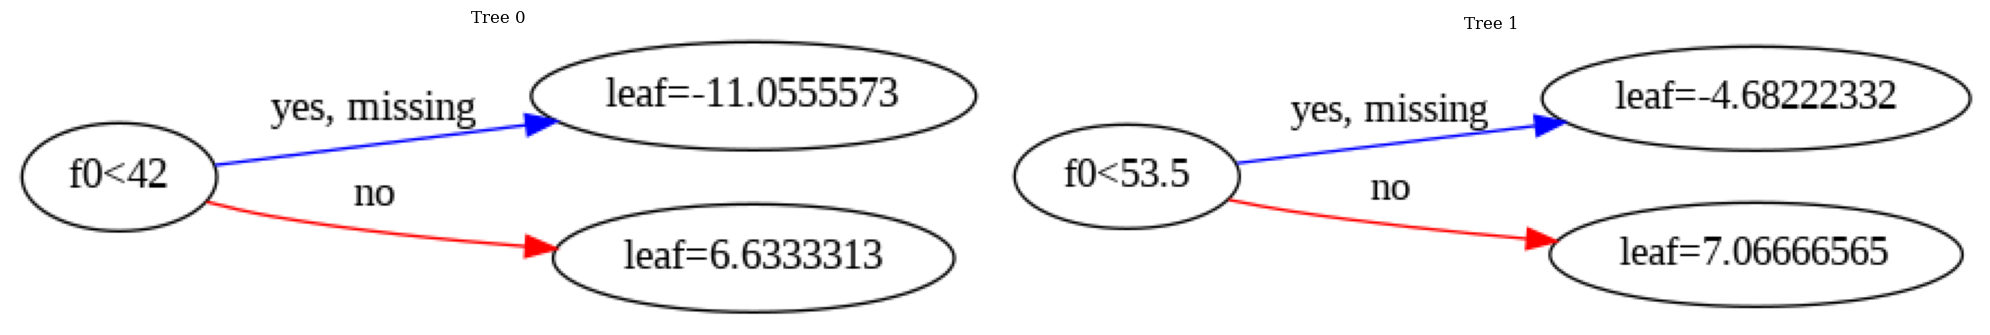

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

n_trees = len(model.get_dump(dump_format='json'))  # nên = 2
print("Num trees:", n_trees)

fig, axes = plt.subplots(1, n_trees, figsize=(10*n_trees, 6))
axes = np.atleast_1d(axes)
for i, ax in enumerate(axes):
    xgb.plot_tree(model, tree_idx=i, rankdir='LR', ax=ax)
    ax.set_title(f"Tree {i}")
plt.tight_layout()
plt.savefig("all_trees.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()


## 3. XGBoost Classification

In [ ]:
# =======================
# XGBoost Binary Classification (logistic loss)
# =======================

import numpy as np
import xgboost as xgb
import json
from typing import Dict, Any, List, Tuple
from supertree import SuperTree
from IPython.display import display

# -----------------------
# Utilities
# -----------------------
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def logistic_grad_hess(margin: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Binary logistic loss: l = -[ y log p + (1-y) log(1-p) ], p = sigmoid(margin)
    g = dl/dmargin = p - y
    h = d2l/dmargin2 = p*(1-p)
    """
    p = sigmoid(margin)
    g = p - y
    h = p * (1.0 - p)
    return g, h

def xgb_gain(GL: float, HL: float, GR: float, HR: float, lmbd: float, gamma: float) -> float:
    """Gain formula (Eq. 7 style) used in XGBoost (same cho logistic vì làm việc trên margin)."""
    G = GL + GR
    H = HL + HR
    term = (GL**2) / (HL + lmbd) + (GR**2) / (HR + lmbd) - (G**2) / (H + lmbd)
    return 0.5 * term - gamma

def route_indices_binary(feature_values: np.ndarray, threshold: float, idx: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Split indices into left (<= thr) and right (> thr). (No missing handling here.)"""
    left_mask = feature_values[idx] <= threshold
    left_idx  = idx[left_mask]
    right_idx = idx[~left_mask]
    return left_idx, right_idx

def parse_tree_json(booster: xgb.Booster, tree_id: int) -> Dict[str, Any]:
    """Get a single tree structure as JSON dict."""
    dump_json = booster.get_dump(dump_format='json')[tree_id]
    return json.loads(dump_json)

def print_node_header(tree_idx: int, path: str, node: Dict[str, Any]):
    is_leaf = 'leaf' in node
    if is_leaf:
        print(f"[Tree {tree_idx}] Node {path} (LEAF): leaf={node['leaf']}, cover={node.get('cover')}")
    else:
        split_feat = node['split']         # e.g., 'f0'
        thr = node['split_condition']
        print(f"[Tree {tree_idx}] Node {path} (SPLIT): {split_feat} < {thr}, gain={node.get('gain')}, cover={node.get('cover')}")

def analyze_node_recursive(
    tree_idx: int,
    node: Dict[str, Any],
    X: np.ndarray,
    feat_names: List[str],
    idx: np.ndarray,
    g: np.ndarray,
    h: np.ndarray,
    params: Dict[str, Any],
    path: str = "0"
):
    """
    Recursively analyze a JSON node:
      - If split: compute (GL,HL,GR,HR), theoretical gain, compare with node["gain"]
      - Recurse to children with their respective index sets.
      - If leaf: print leaf value (already multiplied by eta), also show pre-shrink weight.
    """
    print_node_header(tree_idx, path, node)

    if 'leaf' in node:
        # Leaf value in JSON is already after shrinkage (eta * w*)
        leaf_after_eta = float(node['leaf'])
        eta = float(params.get("eta", 0.3))
        w_star = leaf_after_eta / eta  # pre-shrinkage leaf weight
        print(f"  -> Leaf stats: leaf(after eta)={leaf_after_eta:.6f}, w*(pre-eta)={w_star:.6f}, cover={node.get('cover')}\n")
        return

    # It's a split node
    split_name = node['split']  # e.g., "f0"
    assert split_name.startswith('f'), f"Unexpected split name: {split_name}"
    feat_idx = int(split_name[1:])
    thr = float(node['split_condition'])

    # Partition current indices into L/R
    left_idx, right_idx = route_indices_binary(X[:, feat_idx], thr, idx)

    # Compute GL, HL, GR, HR from current g,h
    GL = float(g[left_idx].sum())
    HL = float(h[left_idx].sum())
    GR = float(g[right_idx].sum())
    HR = float(h[right_idx].sum())

    lmbd = float(params.get("lambda", params.get("reg_lambda", 1.0)))
    gamma = float(params.get("gamma", 0.0))

    theo_gain = xgb_gain(GL, HL, GR, HR, lmbd=lmbd, gamma=gamma)

    print(f"  -> Computed (from data): G_L={GL:.6f}, H_L={HL:.6f}, G_R={GR:.6f}, H_R={HR:.6f}")
    print(f"  -> Gain(theory) = {theo_gain:.6f} | Gain(dump) = {float(node.get('gain', 'nan')):.6f}")
    print(f"  -> Cover(dump)  = {node.get('cover')}   (For logistic, cover = sum p(1-p) = H)")
    print()

    # Recurse
    children = node['children']
    # Left child with left indices
    analyze_node_recursive(tree_idx, children[0], X, feat_names, left_idx, g, h, params, path=path + "-L")
    # Right child with right indices
    analyze_node_recursive(tree_idx, children[1], X, feat_names, right_idx, g, h, params, path=path + "-R")

def analyze_booster_binary_logistic(
    X: np.ndarray,
    y: np.ndarray,
    params: Dict[str, Any],
    num_boost_round: int
):
    """
    Train an XGBoost binary classifier (logistic) and print, for each tree t:
      - previous margins z^{(t-1)} (output_margin=True)
      - gradients g, h (g=p-y, h=p(1-p))
      - for every split: (GL,HL,GR,HR), theoretical gain vs dump gain, cover
      - for every leaf: leaf(after eta), w*(pre-eta)
      - predictions (probability) after each round
    """
    assert set(np.unique(y)).issubset({0,1}), "y must be binary labels {0,1}"
    assert X.ndim == 2, "X should be 2-D array of shape (n_samples, n_features)"

    dtrain = xgb.DMatrix(X, label=y)

    # Important for logistic: base_score is a margin.
    # base_score=0.0  => initial prob = 0.5 for all points.
    params = dict(params)
    params.setdefault("objective", "binary:logistic")
    params.setdefault("eta", 0.5)
    params.setdefault("lambda", 1.0)
    params.setdefault("gamma", 0.0)
    params.setdefault("max_depth", 1)

    booster = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    print("=== User params (effective) ===")
    print(params)
    print()

    for t in range(1, num_boost_round + 1):
        print("="*70)
        print(f"ROUND {t}  (analyzing TREE index {t-1})")
        print("="*70)

        # Margins from trees [0, t-1)
        z_prev = booster.predict(dtrain, iteration_range=(0, t-1), output_margin=True)
        p_prev = sigmoid(z_prev)
        g, h = logistic_grad_hess(z_prev, y)

        print("margin z_prev (first 10):", np.round(z_prev, 6).tolist())
        print("prob   p_prev (first 10):", np.round(p_prev, 6).tolist())
        print("g = p - y (first 10):    ", np.round(g, 6).tolist())
        print("h = p*(1-p) (first 10):  ", np.round(h, 6).tolist())
        print()

        # Parse tree JSON for tree t-1
        tree = parse_tree_json(booster, t-1)

        # Recursively analyze this tree starting from all indices
        n = X.shape[0]
        idx_all = np.arange(n, dtype=int)
        feat_names = [f"f{k}" for k in range(X.shape[1])]
        analyze_node_recursive(
            tree_idx=t-1,
            node=tree,
            X=X,
            feat_names=feat_names,
            idx=idx_all,
            g=g,
            h=h,
            params=params,
            path="0"
        )

        # Predictions after this round (probabilities)
        prob_after = booster.predict(dtrain, iteration_range=(0, t))  # default = prob for binary:logistic
        print("Probabilities after this round:", np.round(prob_after, 6).tolist())
        print()

    # Final probabilities
    prob_final = booster.predict(dtrain)
    print("=== Final predicted probabilities ===")
    print(np.round(prob_final, 6).tolist())
    return booster


# -----------------------
if __name__ == "__main__":
    # X = np.array([0, 1, 2, 3, 4, 5]).reshape(-1, 1)
    # y = np.array([0, 0, 0, 1, 1, 1], dtype=int) # Changed dtype to int
    X = np.array([29, 48, 39, 67, 45, 59]).reshape(-1, 1)
    y = np.array([0, 1, 0, 1, 1, 0], dtype=int) # Changed dtype to int

    params = {
        "objective": "binary:logistic",
        "eta": 0.5,
        "lambda": 1.0,
        "gamma": 0.0,
        "max_depth": 1,
    }
    params.update({
        "min_child_weight": 0.0,
        "base_score": 0.5,
        "subsample": 1.0,
        "colsample_bytree": 1.0,
        "tree_method": "exact",
    })

    model = analyze_booster_binary_logistic(X, y, params, num_boost_round=1)

    st = SuperTree(
        model,
        X,
        y
    )
    st.show_tree()
    xgb.plot_tree(model)
    fig = plt.gcf()
    fig.set_size_inches(50, 30)  # tăng size để có độ phân giải cao

    # Lưu ra file PDF
    plt.savefig("tree2.png", format="png", dpi=300, bbox_inches="tight")
    plt.close()

=== User params (effective) ===
{'objective': 'binary:logistic', 'eta': 0.5, 'lambda': 1.0, 'gamma': 0.0, 'max_depth': 1, 'min_child_weight': 0.0, 'base_score': 0.5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'tree_method': 'exact'}

ROUND 1  (analyzing TREE index 0)
margin z_prev (first 10): [-0.33333298563957214, 0.25, -0.33333298563957214, 0.25, 0.25, 0.25]
prob   p_prev (first 10): [0.41743001341819763, 0.562175989151001, 0.41743001341819763, 0.562175989151001, 0.562175989151001, 0.562175989151001]
g = p - y (first 10):     [0.41743, -0.437823, 0.41743, -0.437823, -0.437823, 0.562177]
h = p*(1-p) (first 10):   [0.2431820034980774, 0.24613399803638458, 0.2431820034980774, 0.24613399803638458, 0.24613399803638458, 0.24613399803638458]

[Tree 0] Node 0 (SPLIT): f0 < 42, gain=None, cover=None
  -> Computed (from data): G_L=0.834860, H_L=0.486364, G_R=-0.751294, H_R=0.984536
  -> Gain(theory) = 0.375259 | Gain(dump) = nan
  -> Cover(dump)  = None   (For logistic, cover = sum p(1-p) = H)